In [56]:
import copy
from typing import Set, Tuple, Optional
from math import log, pi
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# from rpy2.robjects.packages import importr
# import rpy2.robjects as robjects
# import rpy2.robjects.numpy2ri
# rpy2.robjects.numpy2ri.activate()
# HDtest = importr('HDtest')


def calc_likelihood(sigma: np.ndarray) -> float:
    p = sigma.shape[0]

    # sigma = copy.deepcopy(sigma)
    # for i in range(p):
    #     for j in range(i):
    #         sigma[i, j] = sigma[j, i]

    try:
        return -p / 2 * log(2 * pi) - 1 / 2 * log(np.linalg.det(sigma)) - p / 2
    except ValueError:
        print(log(np.linalg.det(sigma)))
        print(sigma)
        raise


def get_sigma(ind: Tuple[int, int], s: np.ndarray, a: Set[Tuple[int, int]]) -> float:
    i, j = ind
    return s[i][j] if ind in a else 0


def get_gamma(ind1: Tuple[int, int], ind2: Tuple[int, int], sig: np.ndarray):
    i, j = ind1
    k, l = ind2

    if i != j:
        if k != l:
            return -(sig[i, k] * sig[j, l] + sig[i, l] * sig[j, k])
        else:
            return -sig[i, k] * sig[j, k]
    else:
        if k != l:
            return -sig[i, k] * sig[j, l]
        else:
            return -1 / 2 * sig[i, k] ** 2


def calc_next_estimation(edges: Set[Tuple[int, int]], sigma: np.ndarray, s: np.ndarray) -> np.ndarray:
    p = s.shape[0]

    inv_sigma = np.linalg.inv(sigma)
    indices = list(edges)

    theta = np.asarray([-s[i, j] if i != j else -1 / 2 * s[i, j] for i, j in indices])

    delta = float('inf')
    eps = 0.0001
    while delta > eps:
        gamma = np.ndarray(shape=(len(edges), len(edges)), dtype=float)

        for i, e1 in enumerate(indices):
            for j, e2 in enumerate(indices):
                gamma[i, j] = get_gamma(e1, e2, sigma)

        fa0 = np.asarray([inv_sigma[i, j] for i, j in indices])
        theta0 = np.asarray([-sigma[i, j] if i != j else -1 / 2 * sigma[i, j] for i, j in indices])

        s = np.linalg.solve(gamma, (theta - theta0))
        new_fa = fa0 - s

        inv_sigma = np.zeros(shape=(p, p))
        for ind, e in enumerate(indices):
            i, j = e
            inv_sigma[i, j] = new_fa[ind]
            inv_sigma[j, i] = new_fa[ind]

        sigma = np.linalg.inv(inv_sigma)

        delta = np.dot(new_fa, new_fa) - np.dot(fa0, fa0)

    return sigma


def get_corr_estimation(cur_estimation: np.ndarray,
                        processed: Set[Tuple[int, int]],
                        correlation_matrix: np.ndarray,
                        significance_level: float):
    p = correlation_matrix.shape[0]
    corr_estimation = cur_estimation.copy()

    cur_delta = float('inf')
    base_likelihood = calc_likelihood(corr_estimation)
    k = len(processed) - p
    while cur_delta >= significance_level / (p * (p - 1) / 2 - k):
        k += 1
        max_delta = 0
        best_edge = None
        for i in range(p):
            for j in range(i, p):
                if (i, j) in processed:
                    continue

                cur_processed = copy.deepcopy(processed)
                cur_processed.add((i, j))
                new_corr_estimation = calc_next_estimation(cur_processed, corr_estimation, correlation_matrix)
                cur_likelihood = calc_likelihood(new_corr_estimation)
                cur_delta = cur_likelihood - base_likelihood
                if cur_delta > max_delta:
                    best_edge = (i, j)
                    max_delta = cur_delta
        if best_edge is None:
            break

        processed.add(best_edge)
        corr_estimation = calc_next_estimation(processed, corr_estimation, correlation_matrix)

        cur_likelihood = calc_likelihood(corr_estimation)
        cur_delta = cur_likelihood - base_likelihood
        base_likelihood = cur_likelihood

    return corr_estimation


def calculate(correlation_matrix: np.ndarray,
              significance_level: float,
              processed: Optional[Set[Tuple[int, int]]] = None) -> np.ndarray:
    p = correlation_matrix.shape[0]

    if not processed:
        processed = set()
    for i in range(p):
        processed.add((i, i))

    return get_corr_estimation(
        np.identity(p),
        processed,
        correlation_matrix,
        significance_level
    )

In [61]:
from sklearn.datasets import make_sparse_spd_matrix

d = 10
theta = make_sparse_spd_matrix(d, alpha=0.9,norm_diag=False)
print(np.linalg.cond(theta))


S = np.linalg.inv(theta)
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

S = correlation_from_covariance(S)
theta = np.linalg.inv(S)
I_true = [(i,j) for i in range(d) for j in range(d) if theta[i,j] == 0]

S_dempster = calculate(S, 0.05)

processed = [(i,i) for i in range(d)]

processed_next = [(i,j) for i in range(d) for j in range(i+1,d) if (theta[i,j] != 0)]

new_corr_estimation = np.identity(d)
for i, j in processed_next:
    processed.append((i,j))

    new_corr_estimation = calc_next_estimation(processed, new_corr_estimation, S)

theta_new = np.linalg.inv(new_corr_estimation)

I_new = [(i,j) for i in range(d) for j in range(d) if theta_new[i,j] == 0]

I_new == I_true

6.096480866116901


True

<AxesSubplot:>

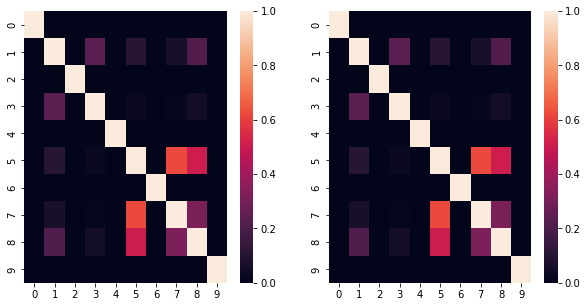

In [64]:
import seaborn as sns
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.heatmap(new_corr_estimation, ax = ax[0])
sns.heatmap(S, ax = ax[1])


R[write to console]: The method 'Scott' does not support skewed data.

R[write to console]: The method 'Scott' does not support skewed data.

R[write to console]: The method 'Scott' does not support skewed data.

R[write to console]: The method 'Scott' does not support skewed data.

R[write to console]: The method 'Scott' does not support skewed data.

R[write to console]: The method 'Scott' does not support skewed data.

R[write to console]: The method 'Scott' does not support skewed data.

R[write to console]: The method 'Scott' does not support skewed data.

R[write to console]: The method 'Scott' does not support skewed data.



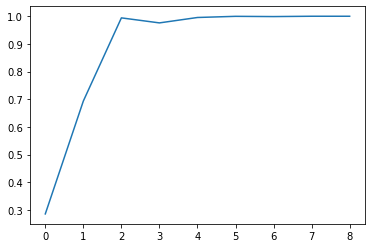

In [55]:
p_vals = []

for n in range(100,1000,100):

    X1 = np.random.multivariate_normal(mean = np.zeros(d), cov = S, size = n)
    X2 = np.random.multivariate_normal(mean = np.zeros(d), cov = S, size = n)

    S_1 = np.cov(X1.T)

    processed = [(i,i) for i in range(d)]
    processed_next = [(i,j) for i in range(d) for j in range(i+1,d) if (theta[i,j] != 0)]
    new_corr_estimation = np.identity(d)
    for i, j in processed_next:
        processed.append((i,j))

        new_corr_estimation = calc_next_estimation(processed, new_corr_estimation, S)

    


    cov_test = HDtest.testCov(new_corr_estimation, S_1)
    cov_test = dict(zip(cov_test.names, list(cov_test)))
    p_vals.append(list(cov_test['CLX'])[1])

plt.plot(p_vals)